In [1]:
import torch
import torchvision
import utility_fn as uf
import glob
import os
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter1d
from metrics import get_metrics

LOG_DIR = './logs'
DATA_DIR = '../datasets'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training and Validation Curves: Ablation Study

In [2]:
def get_model_name(exp_name):
    model_names = ['resnet34', 'mobilenet', 'densenet', 'efficientnet', 'convnext', 'inception', 'attn_inception']
    for m in model_names:
        if exp_name.startswith(m):
            return m
    return None

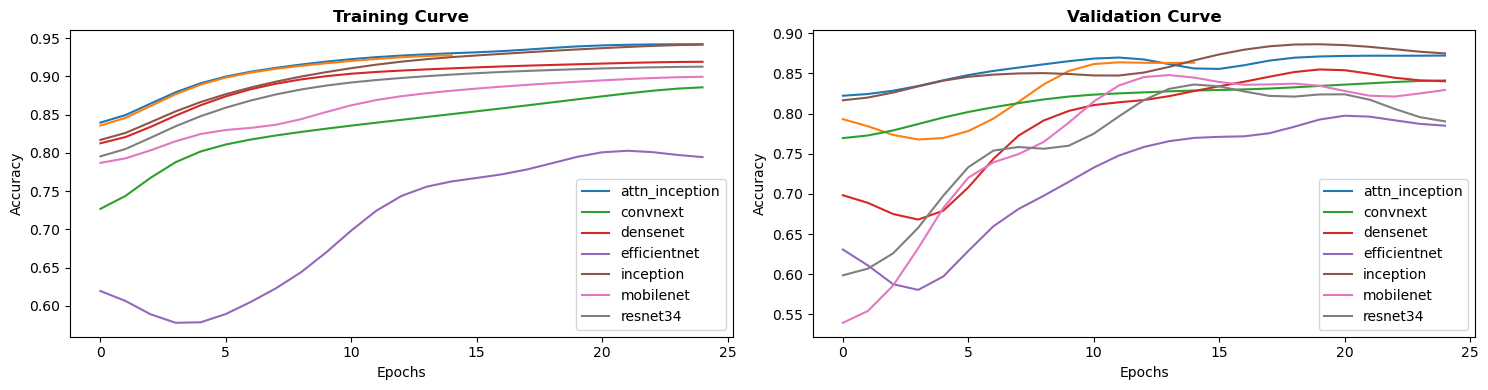

In [3]:
def plot_training_valid_curves():
    fig, ax = plt.subplots(ncols=2, figsize=(15, 4))
    experiments = [e for e in glob.glob(os.path.join(LOG_DIR, 'model_ablation', '*')) if os.path.isdir(e)]
    for exp in experiments:
        history = torch.load(os.path.join(exp,'history.pth'))
        exp_name = os.path.basename(exp)
        train_acc, valid_acc = history['train_acc'], history['valid_acc']
        ax[0].plot(gaussian_filter1d(train_acc, sigma=1.75), label=get_model_name(exp_name))
        ax[1].plot(gaussian_filter1d(valid_acc, sigma=1.75), label=get_model_name(exp_name))

    ax[0].set_title('Training Curve', weight='bold')
    ax[1].set_title('Validation Curve', weight='bold')
    for i in range(2):
        ax[i].legend()
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Accuracy')
    fig.tight_layout()

plot_training_valid_curves()

## Attention InceptionV3

### Confusion Matrix

In [4]:
_, val_loader = uf.get_train_valid_dataloaders('../datasets/PCAM', 128)
model = uf.get_model('attn_inception').to(DEVICE)
model = uf.load_checkpoint(model, './logs/model_ablation/attn_inception_1679782523/best_model.pth', DEVICE)

In [5]:
metrics = get_metrics(model, val_loader, DEVICE)

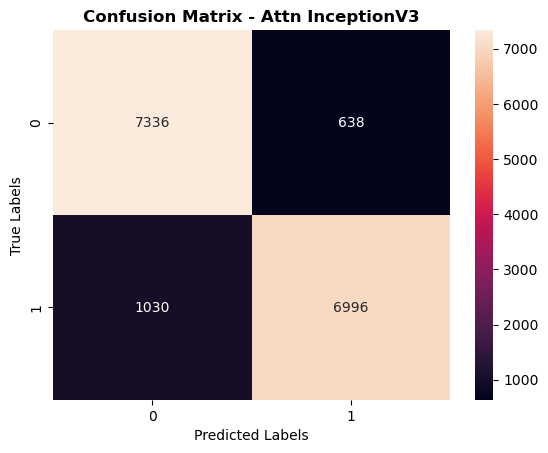

In [6]:
fig, ax = plt.subplots()
sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', ax=ax)
ax.set_title('Confusion Matrix - Attn InceptionV3', weight='bold')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels');

### ROC Curve

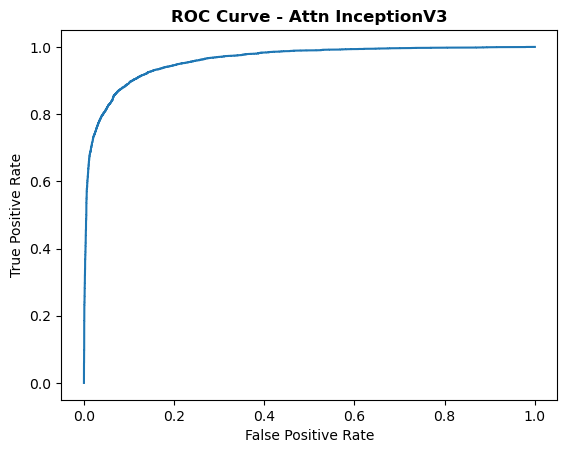

In [7]:
fig, ax = plt.subplots()
fpr, tpr, _ = metrics['roc_curve']
ax.plot(fpr, tpr)
ax.set_title('ROC Curve - Attn InceptionV3', weight='bold')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate');

## Attention Maps

In [8]:
model = uf.get_model('attn_inception', get_attn=True).to(DEVICE)
model = uf.load_checkpoint(model, './logs/model_ablation/attn_inception_1679782523/best_model.pth', DEVICE)

data = torchvision.datasets.ImageFolder('../datasets/PCAM/valid_subset', transform=torchvision.transforms.ToTensor())
idx = [7459, 5552, 9848, 13491, 8997, 8363, 9168, 15852, 3833]
imgs = torch.stack([data[i][0] for i in idx]).to(DEVICE)
labels = torch.tensor([data[i][1] for i in idx]).to(DEVICE)
logits, attn_wgts = model(imgs)

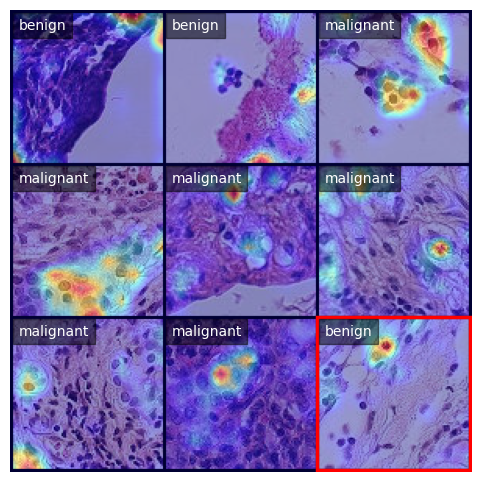

In [9]:
uf.plot_images(imgs, labels, logits.argmax(dim=1), attn_wgts[0]);

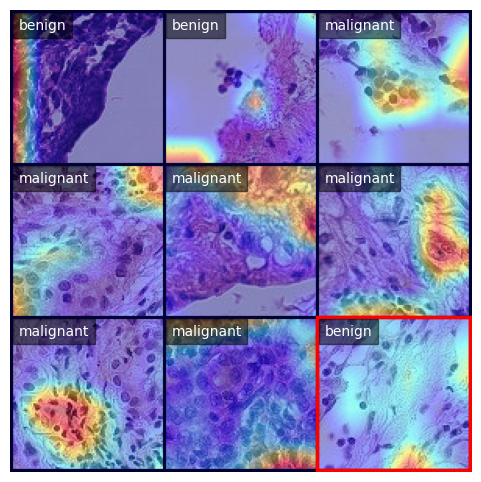

In [10]:
uf.plot_images(imgs, labels, logits.argmax(dim=1), attn_wgts[1]);